# EffecientNet B2 Models Analysis

In [ ]:
import json
import os
import re
import glob
import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torchvision.models import efficientnet_b2
import matplotlib.patches as patches
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from collections import Counter

from torchvision import transforms
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, roc_curve, auc, f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

# importing malaria dataset class to map bounding boxes on one image
# and skipping any null values with detection collate
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from malaria_dataset import MalariaDataset, detection_collate


In [4]:
root_path = os.path.join('..', 'dataset', 'malaria')
image_path = os.path.join('..','dataset','malaria','images')

# using the stratified 
train_json_path = os.path.join(root_path, 'training_stratified.json')
test_json_path = os.path.join(root_path, 'test_stratified.json')

models_dir = os.path.join('effnet_models')
results_path = os.path.join(models_dir,'grid_search_results.json')

In [ ]:
def cells_count(training_dataset_json):
    # Loading the JSON
    with open(training_dataset_json, 'r') as f:
        training_metadata = json.load(f)

    # Extracting all object categories into a list
    all_categories = []
    for item in training_metadata:
        for obj in item['objects']:
            all_categories.append(obj['category'])

    # Create DataFrame and count categories
    df = pd.DataFrame(all_categories, columns=['category'])
    category_counts = df['category'].value_counts()

    return category_counts.to_dict()

counts = cells_count(train_json_path)
print(counts)
counts2 = cells_count(test_json_path)
print(counts2)


{'red blood cell': 76165, 'trophozoite': 1416, 'difficult': 430, 'ring': 349, 'schizont': 178, 'gametocyte': 142, 'leukocyte': 82}
{'red blood cell': 6869, 'ring': 173, 'trophozoite': 168, 'leukocyte': 21, 'difficult': 16, 'gametocyte': 14, 'schizont': 12}


In [7]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1190
Number of entries in test.json: 138


In [8]:
# Load the grid search results
with open(results_path, 'r') as f:
    all_results = json.load(f)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# The 'params' column is a dictionary, let's expand it for better sorting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Sort by accuracy to find the best run
results_df = results_df.sort_values(by='best_accuracy', ascending=False).reset_index(drop=True)

print("  Top 5 Performing Models ")
display(results_df.head())

  Top 5 Performing Models 


best_accuracy  training_time_minutes  \
0      82.261905              25.255350   
1      81.904762              48.805617   
2      79.761905              25.764300   
3      75.833333              88.562786   
4      73.928571              44.540181   

                                             history  batch_size  image_size  \
0  {'train_loss': [0.31937965554626363, 0.1950051...          32         128   
1  {'train_loss': [0.7987523674964905, 0.63951687...          32         224   
2  {'train_loss': [0.8187609330603951, 0.67409247...          32         128   
3  {'train_loss': [0.8987144325908861, 0.77175456...          32         128   
4  {'train_loss': [0.5594567076156014, 0.27973282...          32         224   

       lr optimizer    sampling  
0  0.0010      Adam  oversample  
1  0.0010      Adam        None  
2  0.0010      Adam        None  
3  0.0001      Adam        None  
4  0.0001      Adam  oversample

## Plotting scores

In [9]:
def plot_training_history(history, params):
    """
    Plots the training and validation loss and accuracy curves from a history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    # Create an array for the x-axis (epochs)
    epochs = range(1, len(history['train_loss']) + 1)

    #   Plot 1: Loss vs. Epochs  
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue', marker='o', linestyle='--')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', marker='o')
    ax[0].set_title('Loss Over Epochs', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.5)

    #   Plot 2: Accuracy vs. Epochs  
    ax[1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='royalblue', marker='s', linestyle='--')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green', marker='s')
    ax[1].set_title('Accuracy Over Epochs', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Create a comprehensive title for the entire figure
    param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
    fig.suptitle(f'Training History for Best Model: {param_str}', fontsize=20)
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

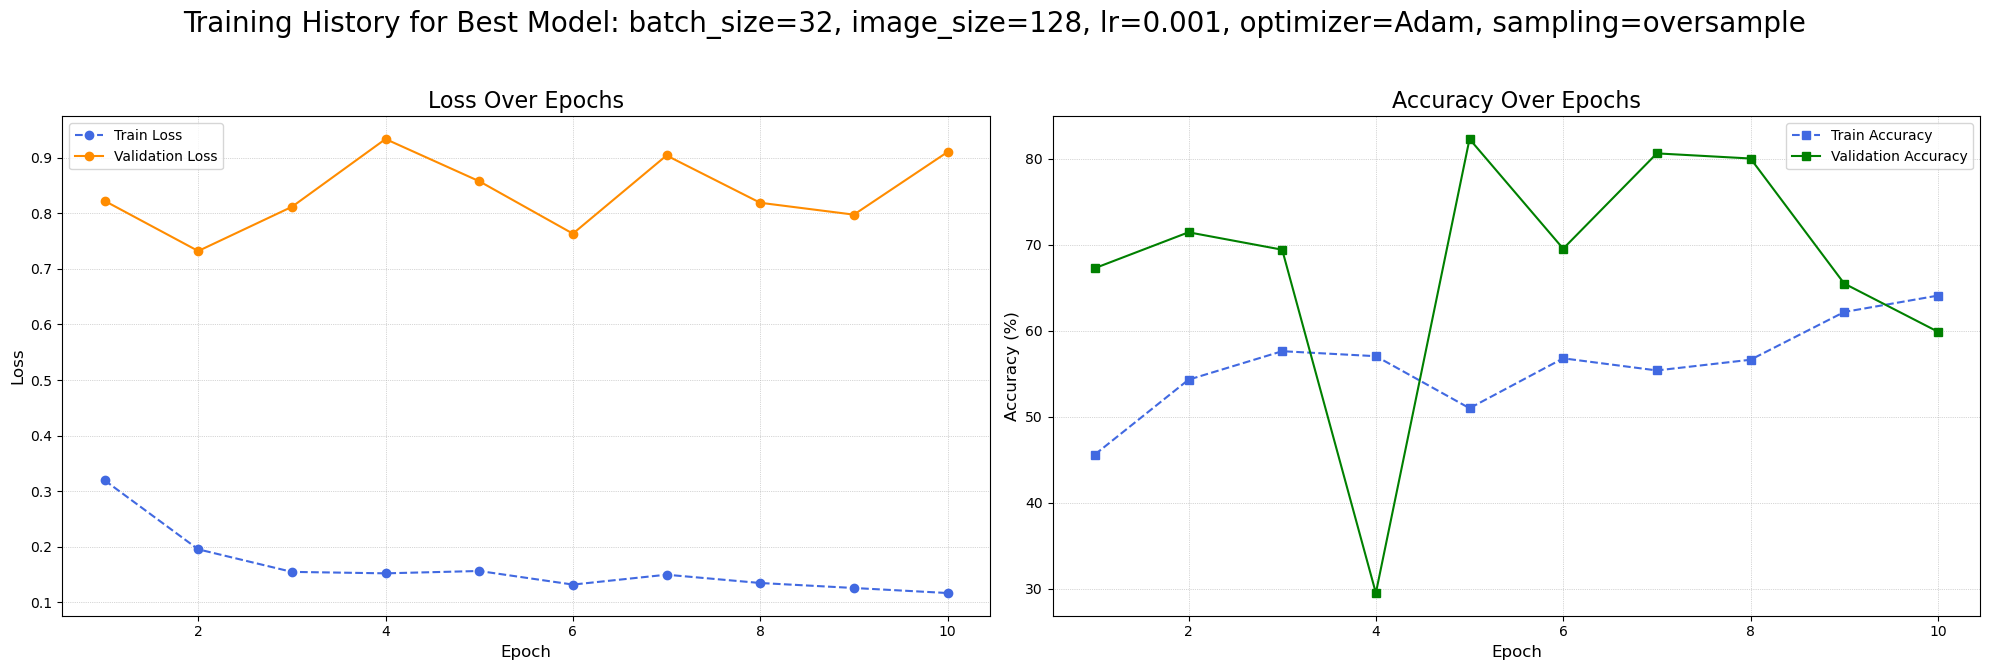

In [10]:
# The history is a string in the JSON, so we need to get it from the original list
best_run_dict = all_results[results_df.index[0]]
best_history = best_run_dict['history']
best_params = best_run_dict['params']

plot_training_history(best_history, best_params) 

In [11]:
def plot_all_grid_search_results(all_results):
    """
    Plots the validation loss and accuracy for all experiments from a grid search on a single graph.
    """
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    
    # Define styles to cycle through to make lines distinguishable
    linestyles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'v', '^', 'D', '<', '>', 'p']
    # Generate a list of distinct colors
    colors = plt.get_cmap('tab20', len(all_results))

    #   Loop through each experiment's results  
    for i, result in enumerate(all_results):
        history = result['history']
        params = result['params']
        
        # Create a short, descriptive label for the legend
        samp_char = 'O' if params.get('sampling', 'none') == 'oversample' else 'N'
        label = f"Run {i+1}: lr={params['lr']}, optim={params['optimizer'][:3]}, size={params['image_size']}, samp={samp_char}"

        epochs = range(1, len(history['val_loss']) + 1)
        
        # Get unique styles for the plot
        style = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        color = colors(i)

        #   Plot 1: Validation Loss vs. Epochs  
        ax[0].plot(epochs, history['val_loss'], label=label, color=color, linestyle=style, marker=marker, markersize=5)
        
        #   Plot 2: Validation Accuracy vs. Epochs  
        ax[1].plot(epochs, history['val_accuracy'], label=label, color=color, linestyle=style, marker=marker, markersize=5)

    #   Formatting for the Loss Plot  
    ax[0].set_title('Validation Loss Comparison', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    #   Formatting for the Accuracy Plot  
    ax[1].set_title('Validation Accuracy Comparison', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Accuracy (%)', fontsize=14)
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # Creating a single, shared legend outside the plot area 
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, title="Experiments")

    #   Overall Figure Title and Layout Adjustment  
    fig.suptitle('Comparison of All 16 Grid Search Experiments', fontsize=24)
    fig.tight_layout(rect=[0, 0, 0.85, 0.96]) 
    
    plt.show()

Plotting a comparison of all 16 experiments...


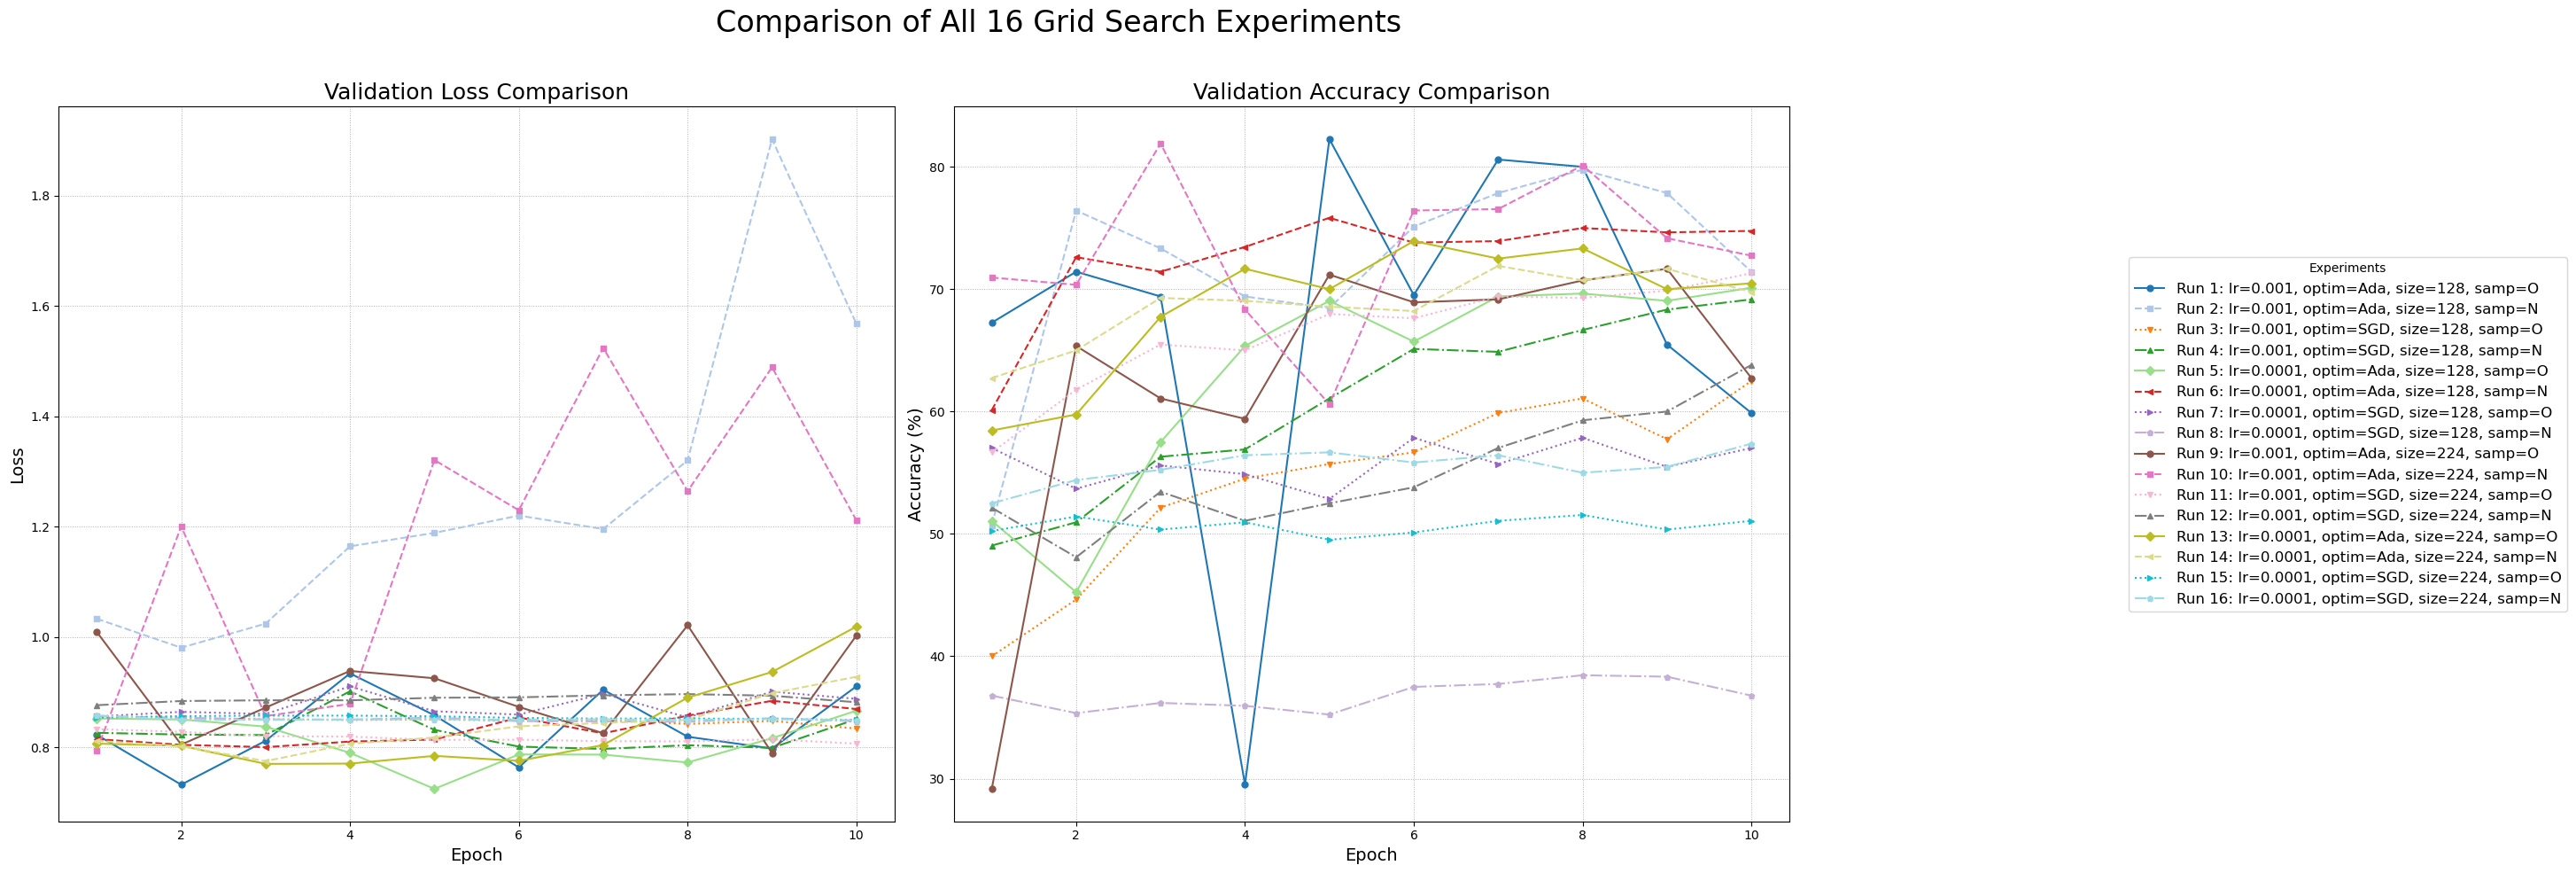

In [12]:
print(f"Plotting a comparison of all {len(all_results)} experiments...")

# Call the new function with your complete results
plot_all_grid_search_results(all_results)

In [13]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetDetector, self).__init__()
        # Loading pre-trained EfficientNet-B2 as the backbone
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        
        # Replacing the final classifier with an identity layer
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        # classifier for multi-label classification
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Pass input through the backbone
        features = self.backbone(x)
        
        # Getting class scores from the classifier
        class_scores = self.classifier(features)
        
        # return the class scores
        return class_scores

## Saving and plotting the validation summary

In [14]:

def validate_model_multilabel(model, loader, device, category_map,
                              threshold=0.5, per_class_thresholds=None,
                              return_preds=False):
    # Safe criterion: use pos_weight_tensor if it exists; otherwise plain BCE
    try:
        # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor.to(device))
        criterion = nn.BCEWithLogitsLoss()
    except NameError:
        criterion = nn.BCEWithLogitsLoss()

    model.eval()
    running_loss, n_batches = 0.0, 0
    y_true_all, y_score_all = [], []

    with torch.no_grad():
        for images, targets_list in tqdm(loader, desc="Validating (multi-label)"):
            if isinstance(images, torch.Tensor) and images.numel() == 0:
                continue

            images = images.to(device)
            logits  = model(images)  # [B, C]
            B, C = logits.shape

            true = torch.zeros((B, C), device=device)
            for i, t in enumerate(targets_list):
                lbls = t['labels']
                if isinstance(lbls, torch.Tensor):
                    lbls = lbls.tolist()
                if lbls:
                    true[i, lbls] = 1.0

            loss = criterion(logits, true)
            running_loss += loss.item()
            n_batches += 1

            y_true_all.append(true.detach().cpu())
            y_score_all.append(torch.sigmoid(logits).detach().cpu())

    y_true  = torch.cat(y_true_all,  dim=0).numpy()
    y_score = torch.cat(y_score_all, dim=0).numpy()

    if per_class_thresholds is not None:
        thr = np.asarray(per_class_thresholds).reshape(1, -1)
        y_pred = (y_score >= thr).astype(int)
    else:
        y_pred = (y_score >= threshold).astype(int)

    exact_match = 100.0 * (y_pred == y_true).all(axis=1).mean()

    if return_preds:
        return (running_loss / max(1, n_batches), exact_match, y_true, y_pred, y_score)
    else:
        micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        return running_loss / max(1, n_batches), exact_match, micro_f1, macro_f1


def calibrate_thresholds(y_true, y_score, metric='f1', grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 19)

    C = y_true.shape[1]
    best_thr = np.full(C, 0.5, dtype=np.float32)

    for c in range(C):
        if y_true[:, c].sum() == 0:
            continue
        best_score, best_t = -1.0, 0.5
        yt = y_true[:, c]
        ys = y_score[:, c]
        for t in grid:
            yp = (ys >= t).astype(int)
            s = f1_score(yt, yp, zero_division=0)  # optimize F1 by default
            if s > best_score:
                best_score, best_t = s, t
        best_thr[c] = best_t

    return best_thr


In [15]:
# Preparing dataset loaders
image_size = best_params['image_size']
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# creating a category map
train_ds_for_map = MalariaDataset(train_json_path, image_path)
category_map = train_ds_for_map.category_map
print('category map:', category_map)

# Now, create the test dataset using that map
train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform, category_map=category_map, image_size=image_size)
test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=category_map, image_size=image_size)

# Create the DataLoader
test_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=detection_collate,
    num_workers=0
)
shuffle = True
sampler = None
# In your run_experiment function or your analysis script...
train_loader = DataLoader(
    train_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=shuffle, 
    sampler=sampler,
    collate_fn=detection_collate,
    num_workers=0  # <-- THE FIX
)

val_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=detection_collate,
    num_workers=0  # <-- THE FIX
)

category map: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Eval device:", device)

# Make sure category_map / num_classes / class_names are available here
temp_ds = MalariaDataset(train_json_path, image_path)  # to get map consistently
category_map = temp_ds.category_map
num_classes = len(category_map)
class_names = [name for name, idx in sorted(category_map.items(), key=lambda x: x[1])]
labels_for_report = list(range(num_classes))

# Load aggregated results produced during training
results_filepath = os.path.join(models_dir, "grid_search_results.json")
with open(results_filepath) as f:
    aggregated_results = json.load(f)

summary_csv_path = os.path.join(models_dir, "all_models_scores2.csv")

# Resume-friendly: read existing summary if present
summary_rows = []
completed_params = set()
if os.path.isfile(summary_csv_path):
    existing_summary_df = pd.read_csv(summary_csv_path)
    summary_rows = existing_summary_df.to_dict('records')
    for _, row in existing_summary_df.iterrows():
        sampling_val = row['sampling'] if pd.notna(row['sampling']) else None
        param_tuple = (row['lr'], row['optimizer'], row['batch_size'], sampling_val, row['image_size'])
        completed_params.add(param_tuple)
    print(f"Resuming... Found {len(summary_rows)} existing results.")
else:
    print("Starting new summary generation.")

# Evaluate each trained model
for entry in tqdm(aggregated_results, desc="Evaluating models"):
    params = entry["params"]
    param_tuple = (params['lr'], params['optimizer'], params['batch_size'], params.get('sampling'), params['image_size'])
    if param_tuple in completed_params:
        continue

    # Build checkpoint filename (must match how you saved it)
    sampling_str = params.get("sampling") or "none"
    model_filename = (
        f"model_lr-{params['lr']}_optim-{params['optimizer']}_"
        f"bs-{params['batch_size']}_sampling-{sampling_str}_size-{params['image_size']}.pth"
    )
    model_path = os.path.join(models_dir, model_filename)
    if not os.path.isfile(model_path):
        print(f"Checkpoint not found for {params}, skipping. Looked for: {model_path}")
        continue

    # Load model
    model = EfficientNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Build per-model test DataLoader (correct image_size)
    image_size = params["image_size"]
    batch_size = params["batch_size"]
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=category_map)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn = detection_collate, num_workers=0)

    # Calibrate thresholds (preferred: on a true val_loader if you have one; fallback: on test)
    # If you have val_ds/val_loader defined elsewhere, use that here.
    _, _, y_true_cal, _, y_score_cal = validate_model_multilabel(
        model, test_loader, device, category_map, threshold=0.5, return_preds=True
    )
    per_class_thr = calibrate_thresholds(y_true_cal, y_score_cal, metric='f1')

    # push RBC threshold higher to curb false positives
    rbc_idx = category_map.get('red blood cell')
    if rbc_idx is not None:
        from sklearn.metrics import precision_recall_curve
        import numpy as np
        prec, rec, thr = precision_recall_curve(y_true_cal[:, rbc_idx], y_score_cal[:, rbc_idx])
        thr = np.r_[thr, 1.0]  # align lengths with prec/rec
        mask = rec >= 0.98
        if mask.any():
            per_class_thr[rbc_idx] = thr[mask][np.argmax(prec[mask])]
        else:
            per_class_thr[rbc_idx] = 0.5

    # Final predictions using calibrated thresholds
    val_loss, exact_acc, y_true, y_pred, y_score = validate_model_multilabel(
        model, test_loader, device, category_map, per_class_thresholds=per_class_thr, return_preds=True
    )
    # test_accuracy = accuracy_score(y_true, y_pred)
    # Report (as dict)
    report_dict = classification_report(
        y_true, y_pred, target_names=class_names, labels=labels_for_report, zero_division=0, output_dict=True
    )

    test_accuracy = accuracy_score(y_true, y_pred)  # subset accuracy (exact match)

    # (b) Robust per-class metrics by index (not by dict keys)
    per_prec = precision_score(y_true, y_pred, average=None, zero_division=0)  # shape (C,)
    per_rec  = recall_score(y_true, y_pred, average=None, zero_division=0)
    per_f1   = f1_score(y_true, y_pred, average=None, zero_division=0)

    # (c) Optional: macro/weighted using sklearn
    macro_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    macro_rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    macro_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

    weighted_prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    weighted_rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    weighted_f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    # Build summary row
    row = {
        "lr": params["lr"],
        "optimizer": params["optimizer"],
        "batch_size": params["batch_size"],
        "sampling": params.get("sampling"),
        "image_size": params["image_size"],
        "train_val_accuracy": entry["best_accuracy"],
        "test_accuracy": test_accuracy,
        "macro_precision": macro_prec,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,
        "weighted_precision": weighted_prec,
        "weighted_recall": weighted_rec,
        "weighted_f1": weighted_f1,
        "training_time_minutes": entry["training_time_minutes"],
    }
    
    for idx, cls_name in enumerate(class_names):
        row[f"{cls_name}_precision"] = float(per_prec[idx])
        row[f"{cls_name}_recall"]    = float(per_rec[idx])
        row[f"{cls_name}_f1"]        = float(per_f1[idx])

    summary_rows.append(row)

    # Save after each model (resumable)
    pd.DataFrame(summary_rows).to_csv(summary_csv_path, index=False)
    print(f"Updated summary with {len(summary_rows)} total results.")

print(f"\n  All models evaluated. Final summary is in {summary_csv_path}  ")


Eval device: cpu
Starting new summary generation.


Evaluating models:   0%|          | 0/16 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [18]:
summary_csv_path = os.path.join(models_dir, "all_models_scores2.csv")
summary_df = pd.read_csv(summary_csv_path)

class_columns = [f"{cls}_{metric}" for cls in class_names for metric in ("precision", "recall", "f1")]

# Colour map that shades higher values more intensely
styled_df = summary_df.style.background_gradient(
    subset=class_columns,
    cmap="Blues",
    vmin=0, vmax=1
).format("{:.3f}", subset=class_columns)
display(styled_df)


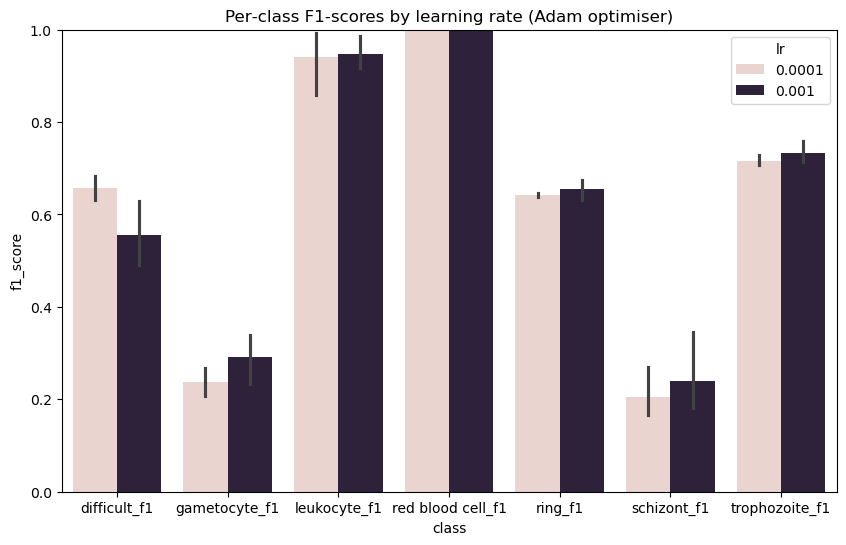

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to a subset if there are many models
plot_df = summary_df[summary_df["optimizer"] == "Adam"]

# Melt the per-class F1 columns into long format
f1_cols = [f"{cls}_f1" for cls in class_names]
melted = plot_df.melt(
    id_vars=["lr", "batch_size", "sampling", "image_size"],
    value_vars=f1_cols,
    var_name="class",
    value_name="f1_score"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted,
    x="class",
    y="f1_score",
    hue="lr"
)
plt.title("Per‑class F1‑scores by learning rate (Adam optimiser)")
plt.ylim(0, 1)
plt.show()


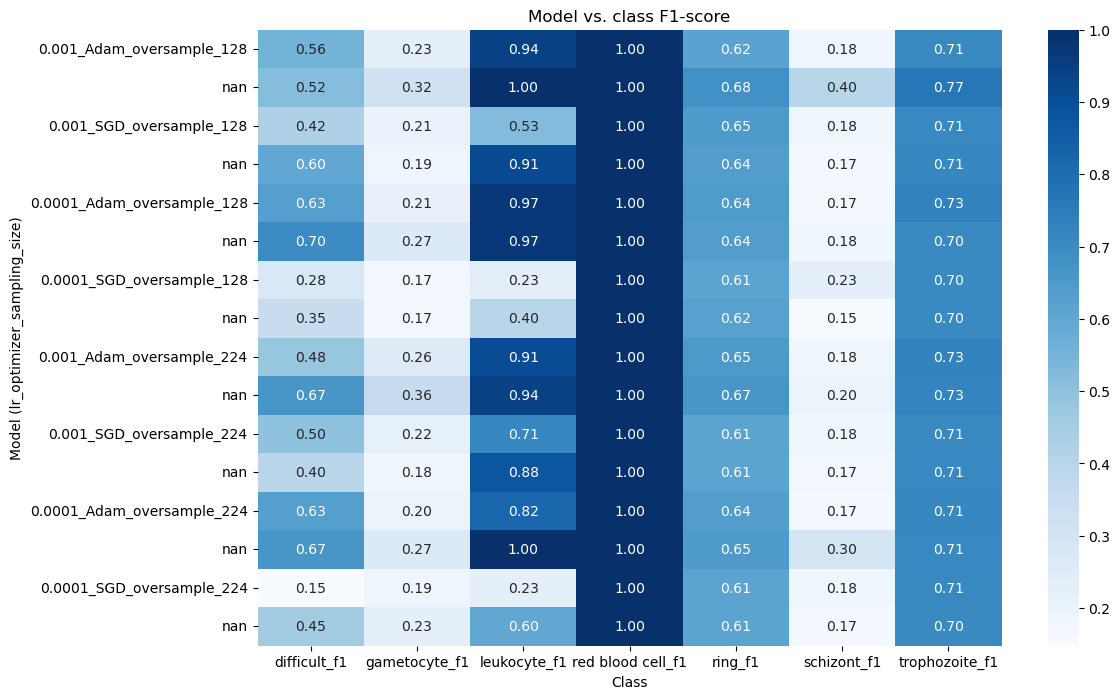

In [16]:
# Build a pivot table: rows = models, columns = class F1-scores
row_index = (summary_df["lr"].astype(str) + "_" +
             summary_df["optimizer"] + "_" +
             summary_df["sampling"] + "_" +
             summary_df["image_size"].astype(str))
heatmap_df = summary_df.set_index(row_index)[f1_cols]

plt.figure(figsize=(12, len(heatmap_df)/2))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Model vs. class F1-score")
plt.xlabel("Class")
plt.ylabel("Model (lr_optimizer_sampling_size)")
plt.show()


### Model prediction

In [17]:
# Create a single dictionary to hold all ground truth entries
all_entries_map = {}

# Populate the map from the training dataset
for entry in train_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

# Add/overwrite with entries from the test dataset
for entry in test_ds.entries:
    filename = os.path.basename(entry['image']['pathname'])
    all_entries_map[filename] = entry

print(f"Created a lookup map with {len(all_entries_map)} total unique image entries.")

Created a lookup map with 1328 total unique image entries.


## Gradcam

In [18]:
class GradCAM:
    """
    A robust Grad-CAM class that properly manages and removes hooks.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Store hook handles to be able to remove them later
        self.handles = []
        self._register_hooks()

    def _capture_activations(self, module, input, output):
        self.activations = output.detach()

    def _capture_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def _register_hooks(self):
        # Register hooks and store their handles
        handle_forward = self.target_layer.register_forward_hook(self._capture_activations)
        handle_backward = self.target_layer.register_full_backward_hook(self._capture_gradients)
        self.handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        # Use the stored handles to remove the hooks
        for handle in self.handles:
            handle.remove()

    def generate_heatmap(self, model_output, class_idx):
        if class_idx is None:
            class_idx = model_output.argmax(dim=1)
        
        self.model.zero_grad()
        model_output[0, class_idx].backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu()
        heatmap = F.relu(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-8)
        
        return heatmap.numpy()

In [19]:
def visualize_prediction_with_gradcam(
    model, image_path, all_entries_map, device, class_names,
    model_name="", image_size=224, threshold=0.5
):
    """
    Performs a prediction on a single image, prints a summary of
    predicted vs. ground truth labels and infection status, and displays
    both the Grad-CAM heatmap and the ground-truth bounding boxes.
    """
    # Define which classes indicate infection
    parasite_classes = {"gametocyte", "trophozoite", "schizont", "ring"}

    target_layer = model.backbone.features[-1]
    grad_cam = GradCAM(model, target_layer)

    try:
        if model_name:
            print(f"\n### Model: {model_name} ###")
        print(f"  Processing image: {os.path.basename(image_path)}  ")
        # Define which classes indicate infection
        print(f"  Processing image: {os.path.basename(image_path)}  ")
        image_pil = Image.open(image_path).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image_tensor = transform(image_pil).unsqueeze(0).to(device)

        model.eval()
        output = model(image_tensor)  # keep gradients enabled
        class_scores = output[0] if isinstance(output, tuple) else output

        # Aggregate over boxes if necessary
        if class_scores.dim() == 3:
            # sum scores over the box dimension -> shape (1, n_classes)
            class_scores_agg = class_scores.sum(dim=1)
        else:
            class_scores_agg = class_scores

        # Convert to probabilities and determine predicted labels
        probabilities = torch.sigmoid(class_scores_agg[0])
        predicted_indices = (probabilities >= threshold).nonzero(as_tuple=True)[0]
        predicted_labels = {class_names[i] for i in predicted_indices}

        # Sort probabilities for a readable breakdown
        all_scores = sorted(
            [(class_names[i], probabilities[i].item()) for i in range(len(class_names))],
            key=lambda x: x[1],
            reverse=True,
        )
        print("\n  Prediction Breakdown  ")
        for cname, score in all_scores:
            print(f"  - {cname:<15}: {score*100:.2f}%")

        # Ground-truth extraction
        filename = os.path.basename(image_path)
        gt_entry = all_entries_map.get(filename)
        gt_labels = set()
        if gt_entry and gt_entry.get("objects"):
            gt_labels = {obj["category"] for obj in gt_entry["objects"]}
        print("\n  Ground Truth Breakdown  ")
        if gt_entry and gt_entry.get("objects"):
            freqs = Counter(obj["category"] for obj in gt_entry["objects"])
            for cname, cnt in freqs.most_common():
                print(f"  - {cname:<15}: {cnt}")
        else:
            print("  - No ground truth objects listed for this image.")

        # Infection status
        predicted_status = "Infected" if predicted_labels & parasite_classes else "Not Infected"
        actual_status = "Infected" if gt_labels & parasite_classes else "Not Infected"
        diagnosis_correct = predicted_status == actual_status

        print("\n  Final Diagnosis  ")
        print(f"Model Diagnosis: {predicted_status} | Actual Status: {actual_status}")

        # Comparison of labels
        true_positives = predicted_labels & gt_labels
        false_positives = predicted_labels - gt_labels
        false_negatives = gt_labels - predicted_labels
        print("\n  Prediction Summary  ")
        print(f"Correctly Predicted: {', '.join(true_positives) if true_positives else 'None'}")
        print(f"Missed: {', '.join(false_negatives) if false_negatives else 'None'}")
        print(f"Incorrectly Predicted: {', '.join(false_positives) if false_positives else 'None'}")

        # Grad-CAM for the top class
        top_class_idx = probabilities.argmax().item()
        top_class_name = class_names[top_class_idx]
        print(f"\nGenerating Grad-CAM for the top prediction: '{top_class_name}'")
        heatmap = grad_cam.generate_heatmap(class_scores_agg, class_idx=top_class_idx)

        # Prepare heatmap overlay
        heatmap_resized = cv2.resize(heatmap, (image_pil.width, image_pil.height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        image_np = np.array(image_pil)
        overlay_img = cv2.addWeighted(image_np, 0.6, heatmap_colored, 0.4, 0)

        # When plotting, you can set a suptitle or include model_name in the subplot title
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        # Left-hand title includes the model name and the top class
        left_title = f"{model_name}\nGrad-CAM: '{top_class_name}' ({probabilities[top_class_idx]*100:.2f}%)"
        ax1.imshow(overlay_img)
        ax1.set_title(left_title, color="green" if diagnosis_correct else "red")
        ax1.axis("off")
        if predicted_labels:
            ax1.text(0.02, 0.98, "Predicted Classes:\n" + "\n".join(f"- {c}" for c in sorted(predicted_labels)),
                     transform=ax1.transAxes, fontsize=10, va="top",
                     bbox=dict(boxstyle="round", facecolor="limegreen", alpha=0.6))

        # Right: Ground truth boxes and labels
        ax2.imshow(image_np)
        ax2.set_title(f"Ground Truth: {actual_status}")
        ax2.axis("off")
        if gt_entry and gt_entry.get("objects"):
            for obj in gt_entry["objects"]:
                bb = obj["bounding_box"]
                rect = patches.Rectangle(
                    (bb["minimum"]["c"], bb["minimum"]["r"]),
                    bb["maximum"]["c"] - bb["minimum"]["c"],
                    bb["maximum"]["r"] - bb["minimum"]["r"],
                    linewidth=2, edgecolor="gold", facecolor="none"
                )
                ax2.add_patch(rect)
                ax2.text(bb["minimum"]["c"], bb["minimum"]["r"] - 10,
                         obj["category"], color="black", fontsize=8,
                         bbox=dict(facecolor="gold", alpha=0.7, edgecolor="none"))

        plt.tight_layout()
        plt.show()

    finally:
        grad_cam.remove_hooks()


[{'params': {'batch_size': 32, 'image_size': 128, 'lr': 0.001, 'optimizer': 'Adam', 'sampling': 'oversample'}, 'best_accuracy': 82.26190476190476, 'training_time_minutes': 25.255349973837536, 'history': {'train_loss': [0.31937965554626363, 0.19500518413750748, 0.15437806387873074, 0.15174652341949313, 0.15597850201945557, 0.13148722910371266, 0.1492785124941484, 0.13434890167493568, 0.12534573764883375, 0.1162869737630612], 'train_accuracy': [45.61258278145695, 54.3046357615894, 57.615894039735096, 57.0364238410596, 50.99337748344371, 56.788079470198674, 55.38079470198676, 56.62251655629139, 62.16887417218543, 64.0728476821192], 'val_loss': [0.8227401673793793, 0.7323597520589828, 0.8119432181119919, 0.9340741485357285, 0.8580823093652725, 0.7636357247829437, 0.9044900834560394, 0.819258376955986, 0.7978673428297043, 0.9106655269861221], 'val_accuracy': [67.26190476190477, 71.42857142857143, 69.4047619047619, 29.523809523809526, 82.26190476190476, 69.52380952380952, 80.5952380952381, 8

C:\Users\shera\AppData\Local\Temp\ipykernel_29632\200457518.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



### Model: model_lr-0.001_optim-ADAM_bs-32_sampling-none_size-128.pth ###
  Processing image: fc15659f-6264-4dd5-ab17-43d89fb297b9.png  
  Processing image: fc15659f-6264-4dd5-ab17-43d89fb297b9.png  

  Prediction Breakdown  
  - schizont       : 40.60%
  - difficult      : 40.12%
  - red blood cell : 39.14%
  - trophozoite    : 23.36%
  - leukocyte      : 6.68%
  - gametocyte     : 5.00%
  - ring           : 0.65%

  Ground Truth Breakdown  
  - red blood cell : 44
  - difficult      : 2
  - trophozoite    : 1

  Final Diagnosis  
Model Diagnosis: Not Infected | Actual Status: Infected

  Prediction Summary  
Correctly Predicted: None
Missed: difficult, trophozoite, red blood cell
Incorrectly Predicted: None

Generating Grad-CAM for the top prediction: 'schizont'


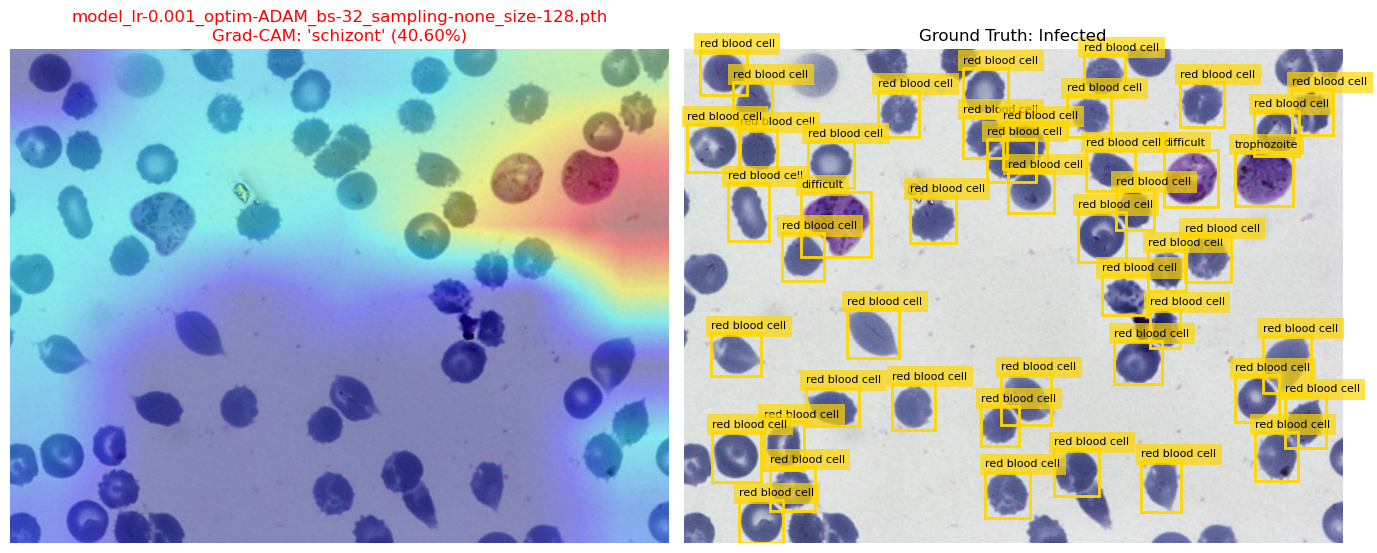

In [26]:
my_image_path = os.path.join(image_path, 'fc15659f-6264-4dd5-ab17-43d89fb297b9.png')
print(aggregated_results)

# for entry in aggregated_results:
for i in range(1):
    params = entry["params"]
    sampling_str = params.get("sampling") or "none"
    # model_file = (
    #     f"model_lr-{params['lr']}_optim-{params['optimizer']}_"
    #     f"bs-{params['batch_size']}_sampling-{sampling_str}_size-{params['image_size']}.pth"
    # )
    model_file = (
        f"model_lr-0.001_optim-ADAM_"
        f"bs-32_sampling-none_size-128.pth"
    )
    model_path = os.path.join(models_dir, model_file)
    if not os.path.isfile(model_path):
        continue

    model = EfficientNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    visualize_prediction_with_gradcam(
        model=model,
        image_path=my_image_path,
        all_entries_map=all_entries_map,
        device=device,
        class_names=class_names,
        model_name=model_file,
        image_size=params["image_size"],
        threshold=0.55
    )


Found 16 models to evaluate using glob.


Evaluating Models:   0%|          | 0/16 [00:00<?, ?it/s]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': None, 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6725
Skipping red blood cell (only one class present in y_true).


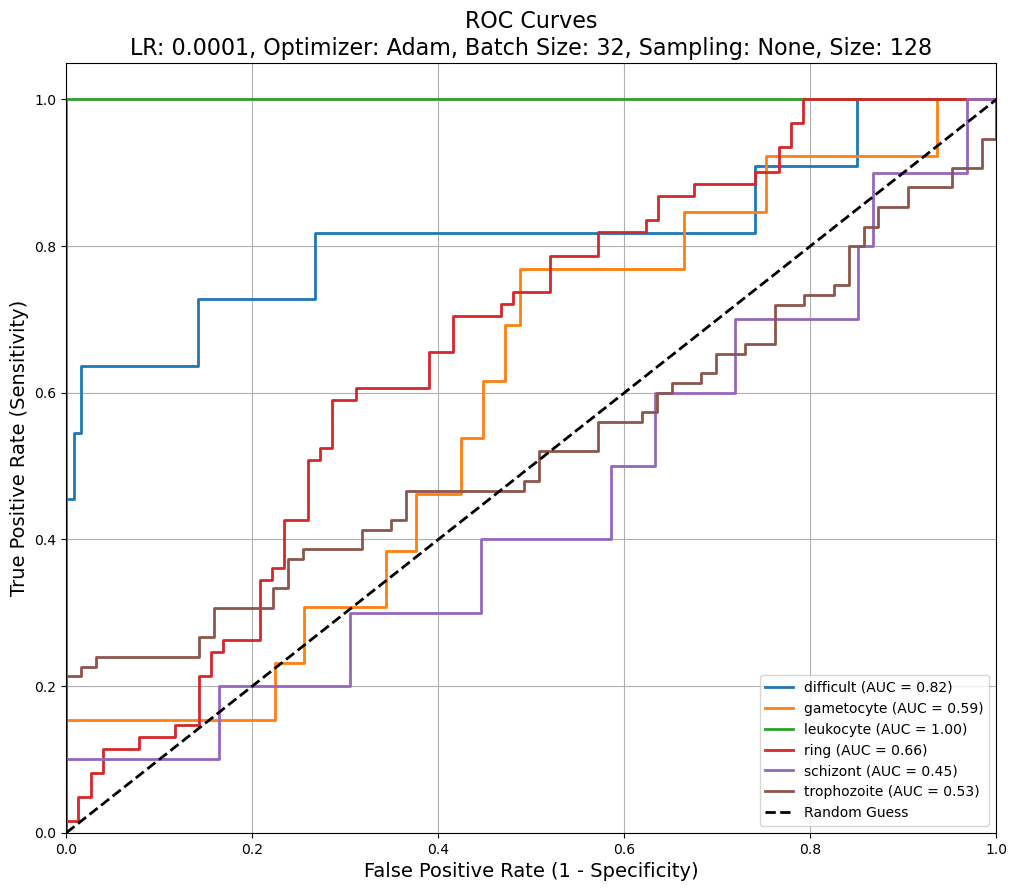

Evaluating Models:   6%|▋         | 1/16 [00:14<03:37, 14.48s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': None, 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.7001
Skipping red blood cell (only one class present in y_true).


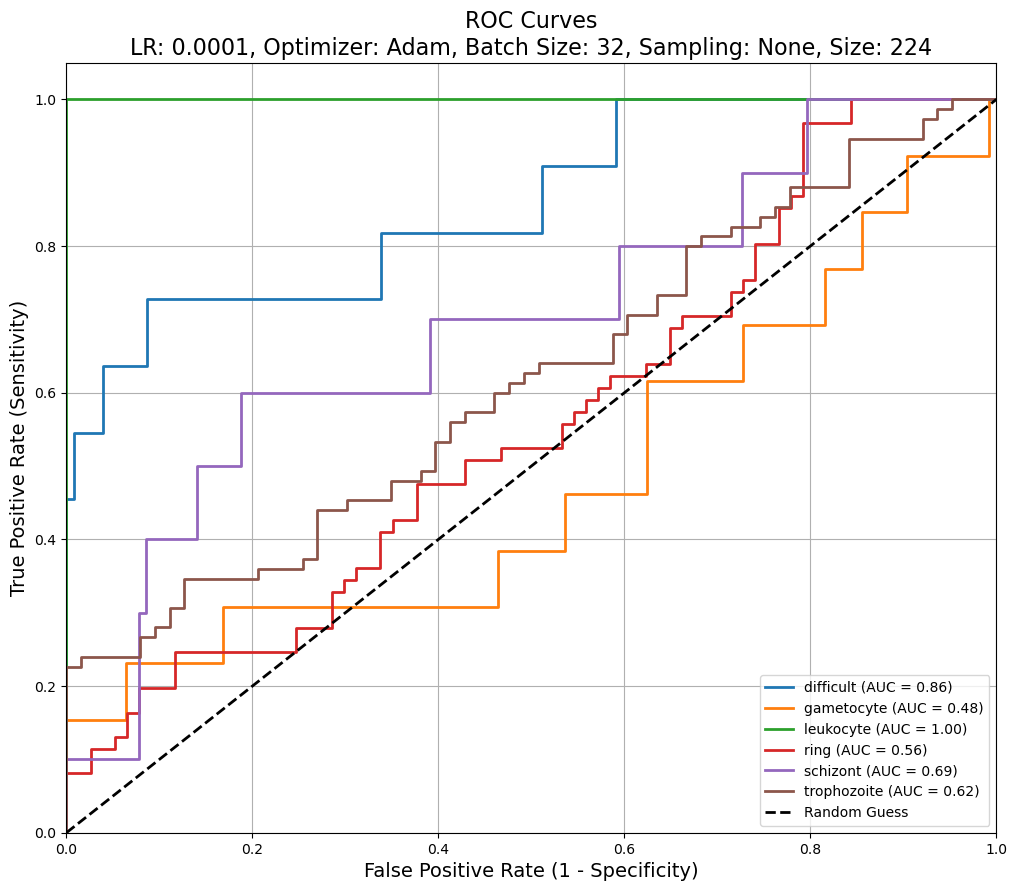

Evaluating Models:  12%|█▎        | 2/16 [00:34<04:04, 17.50s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6776
Skipping red blood cell (only one class present in y_true).


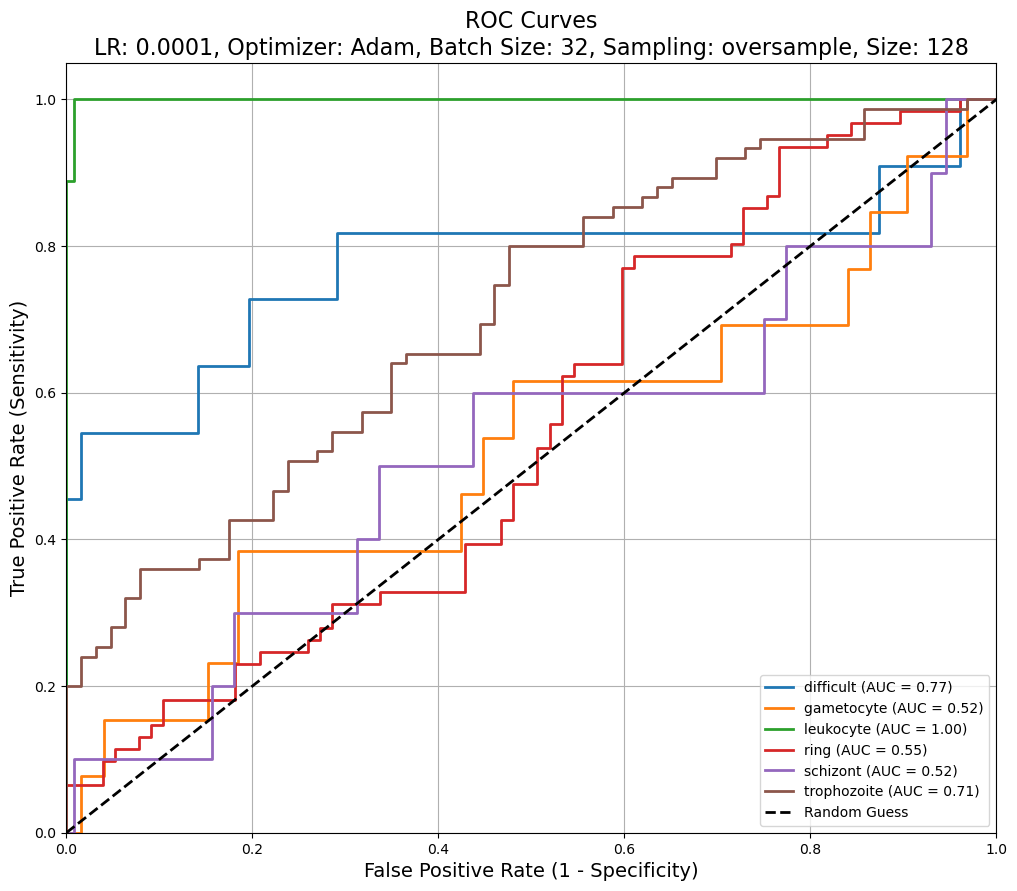

Evaluating Models:  19%|█▉        | 3/16 [00:49<03:36, 16.62s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:20<00:00,  4.09s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6690
Skipping red blood cell (only one class present in y_true).


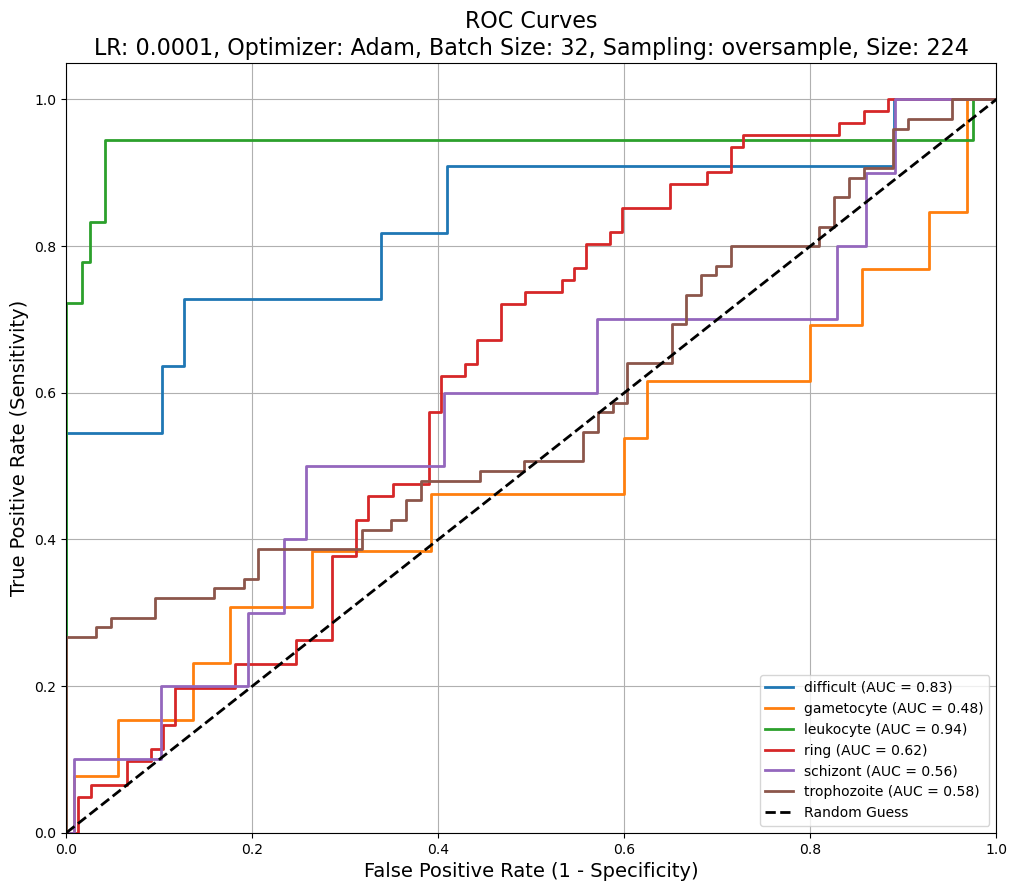

Evaluating Models:  25%|██▌       | 4/16 [01:11<03:42, 18.55s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': None, 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.5842
Skipping red blood cell (only one class present in y_true).


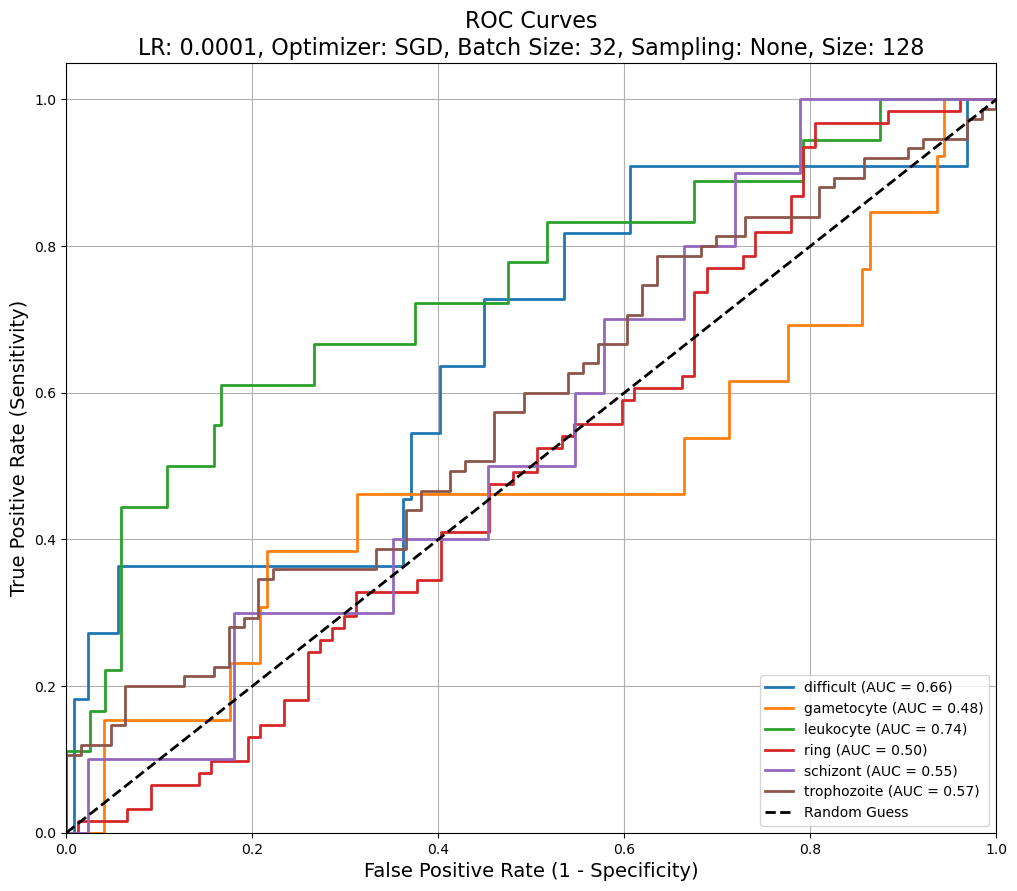

Evaluating Models:  31%|███▏      | 5/16 [01:29<03:21, 18.29s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': None, 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6158
Skipping red blood cell (only one class present in y_true).


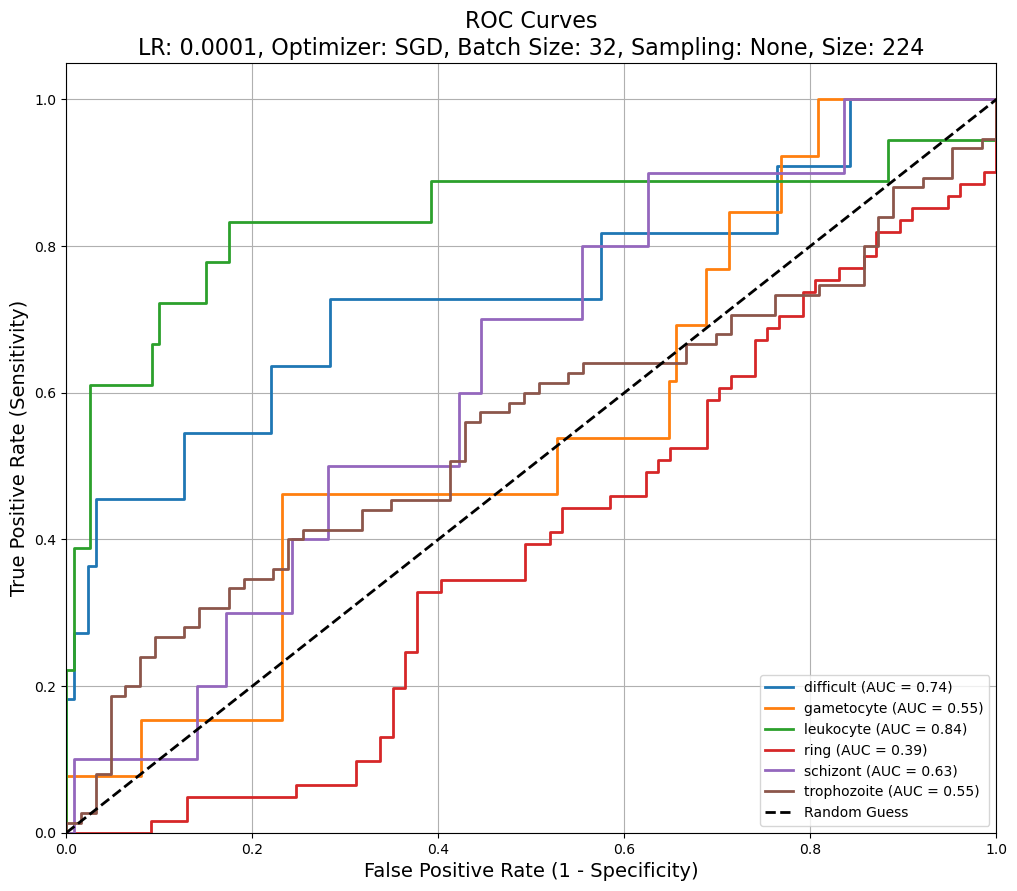

Evaluating Models:  38%|███▊      | 6/16 [01:48<03:08, 18.83s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.5397
Skipping red blood cell (only one class present in y_true).


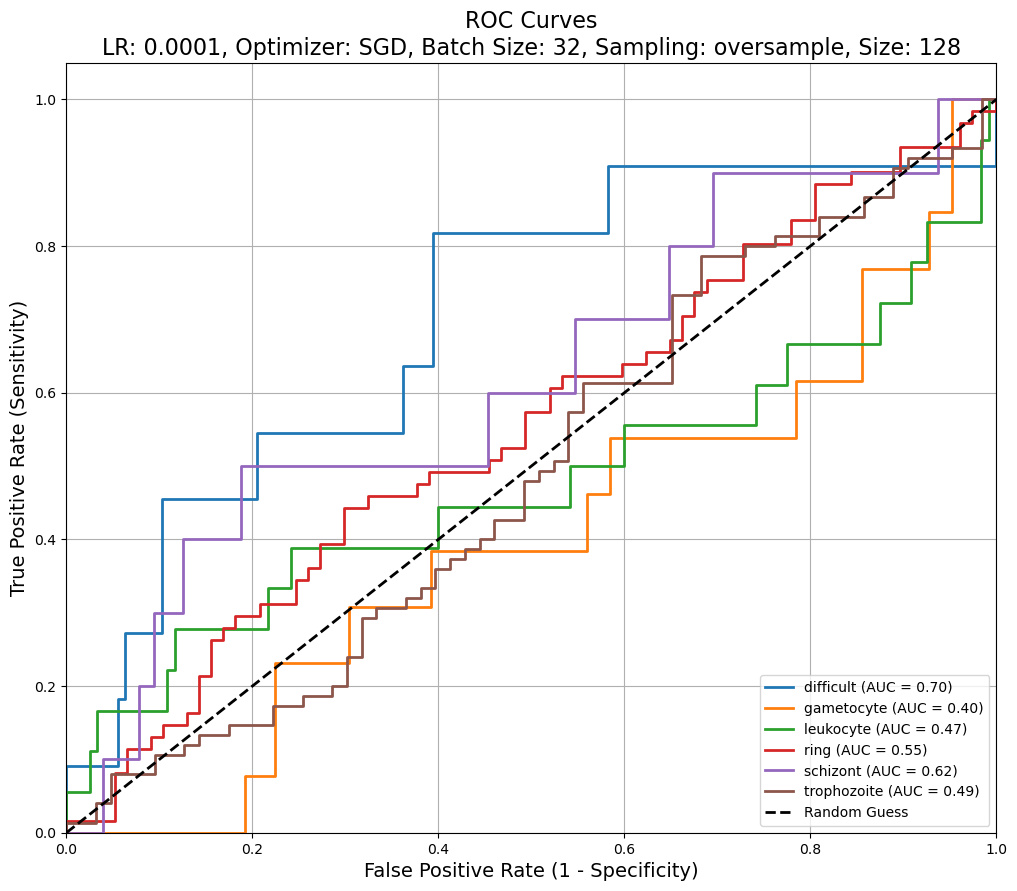

Evaluating Models:  44%|████▍     | 7/16 [02:04<02:39, 17.67s/it]


Generating ROC Plot for model with params: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.4728
Skipping red blood cell (only one class present in y_true).


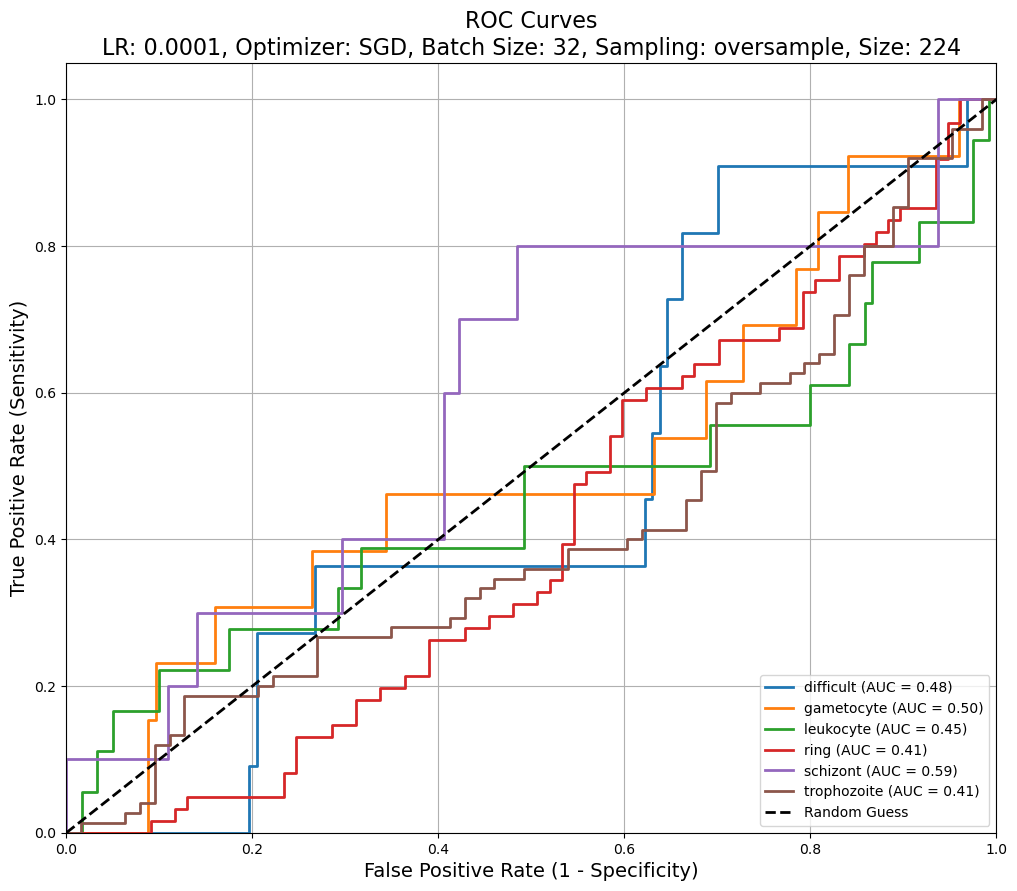

Evaluating Models:  50%|█████     | 8/16 [02:23<02:26, 18.30s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': None, 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.8009
Skipping red blood cell (only one class present in y_true).


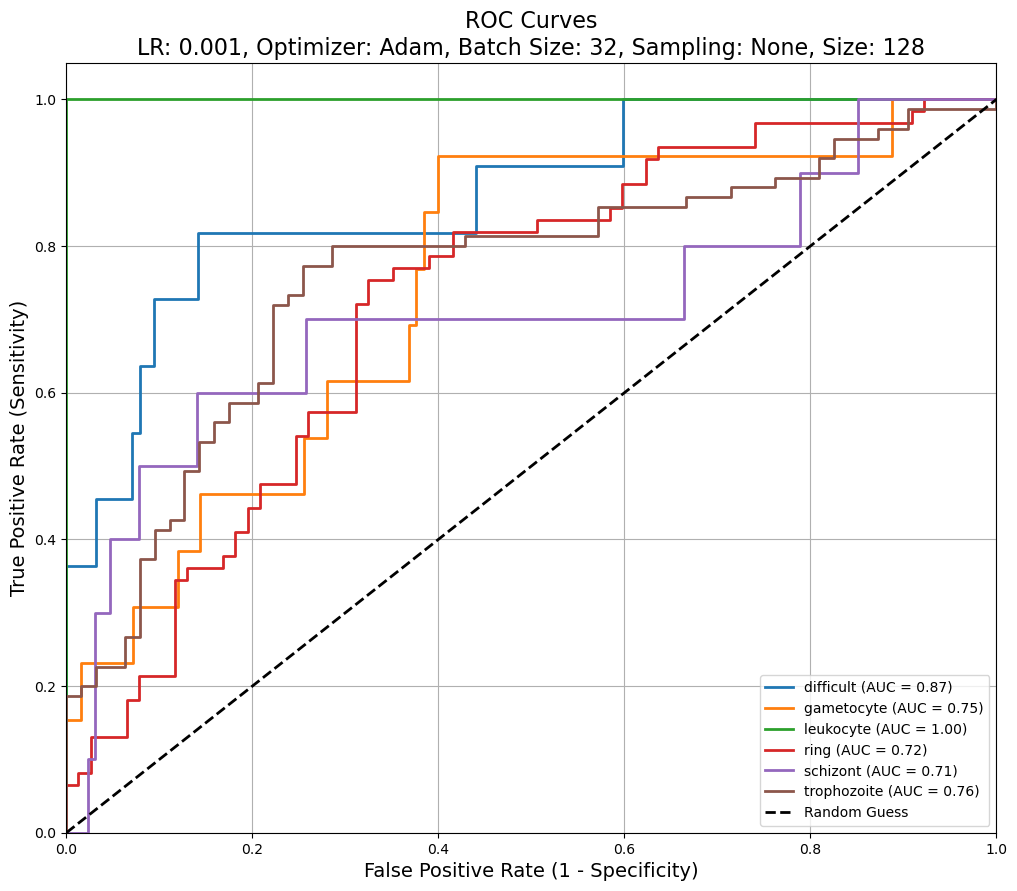

Evaluating Models:  56%|█████▋    | 9/16 [02:40<02:04, 17.84s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': None, 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.7669
Skipping red blood cell (only one class present in y_true).


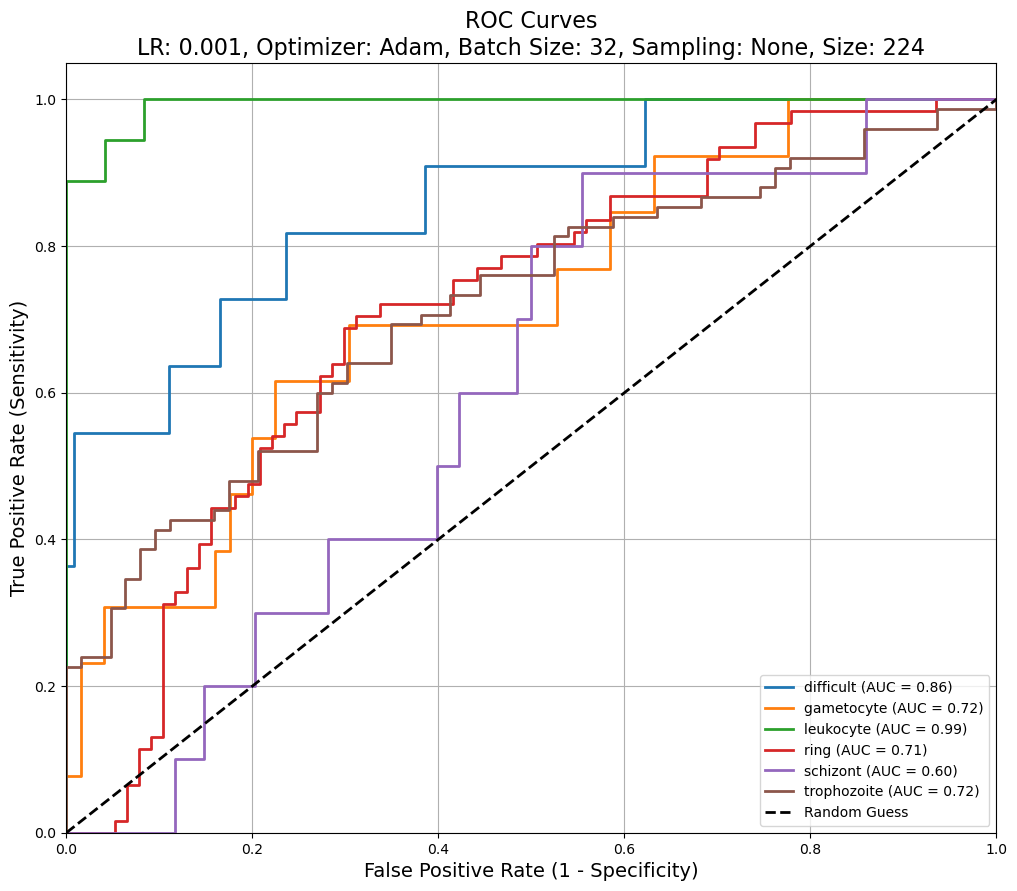

Evaluating Models:  62%|██████▎   | 10/16 [03:00<01:51, 18.54s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6846
Skipping red blood cell (only one class present in y_true).


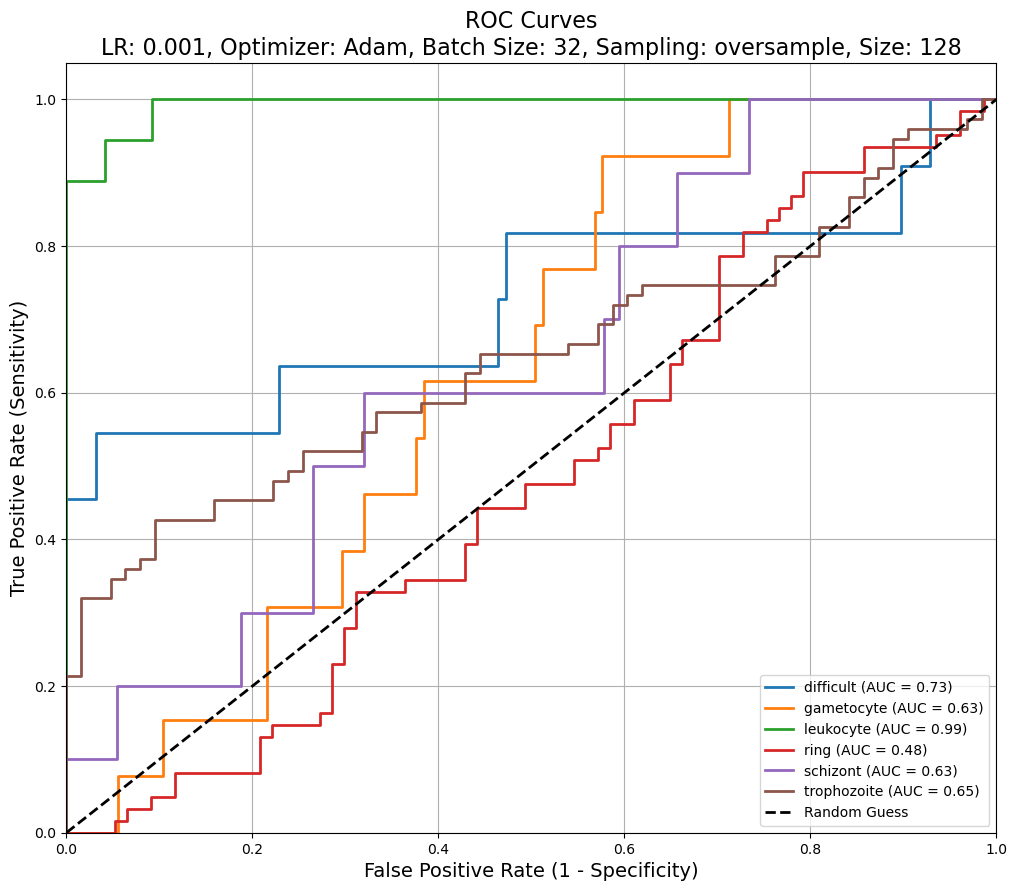

Evaluating Models:  69%|██████▉   | 11/16 [03:18<01:31, 18.26s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:19<00:00,  3.93s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.7193
Skipping red blood cell (only one class present in y_true).


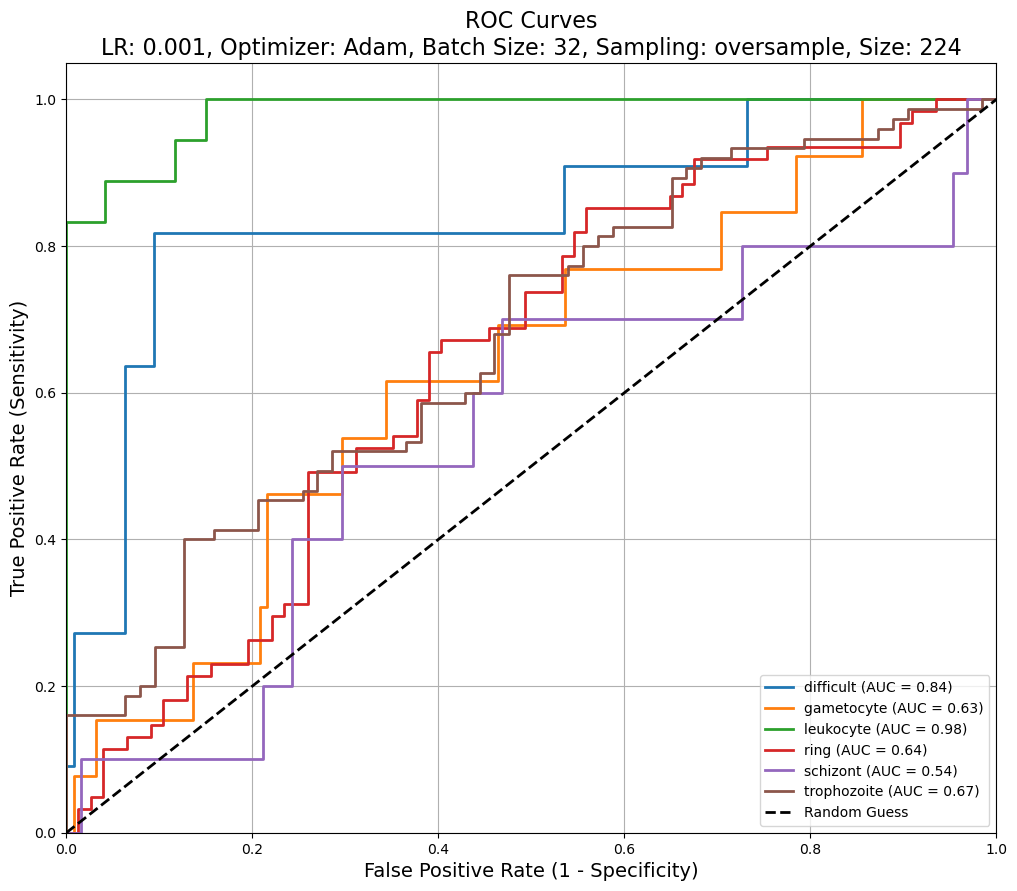

Evaluating Models:  75%|███████▌  | 12/16 [03:39<01:16, 19.01s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': None, 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6341
Skipping red blood cell (only one class present in y_true).


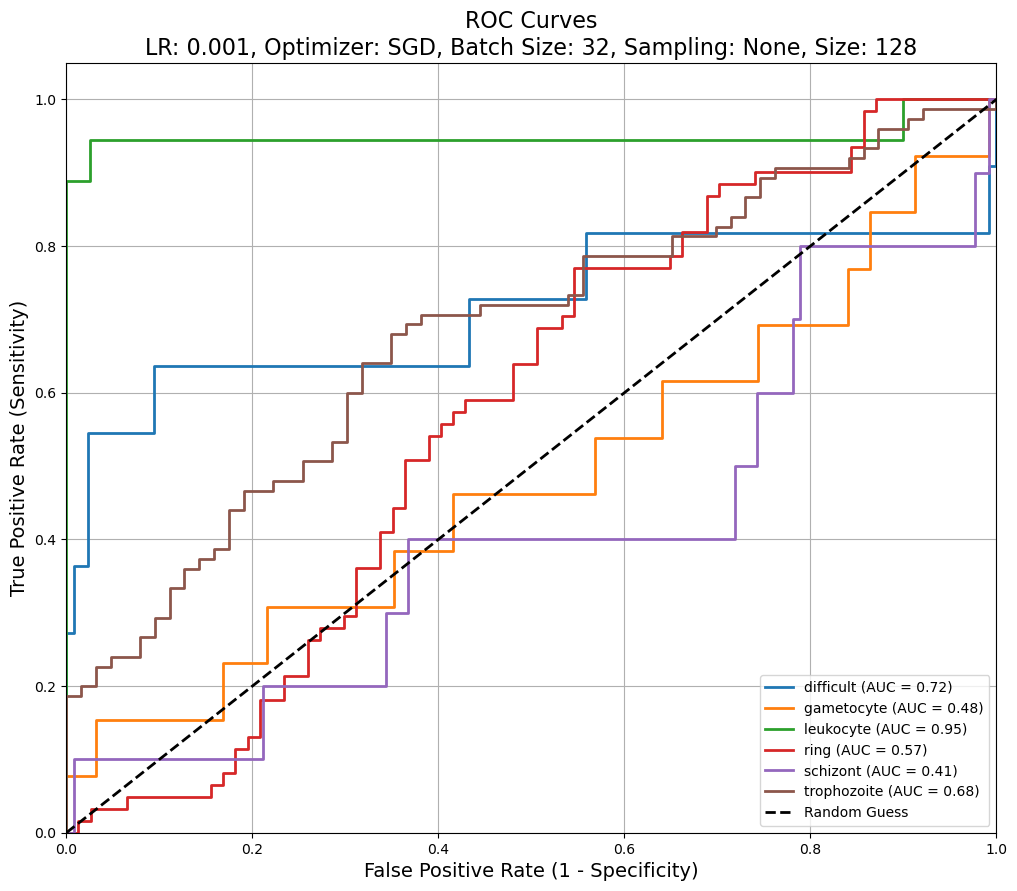

Evaluating Models:  81%|████████▏ | 13/16 [03:55<00:54, 18.10s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': None, 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6397
Skipping red blood cell (only one class present in y_true).


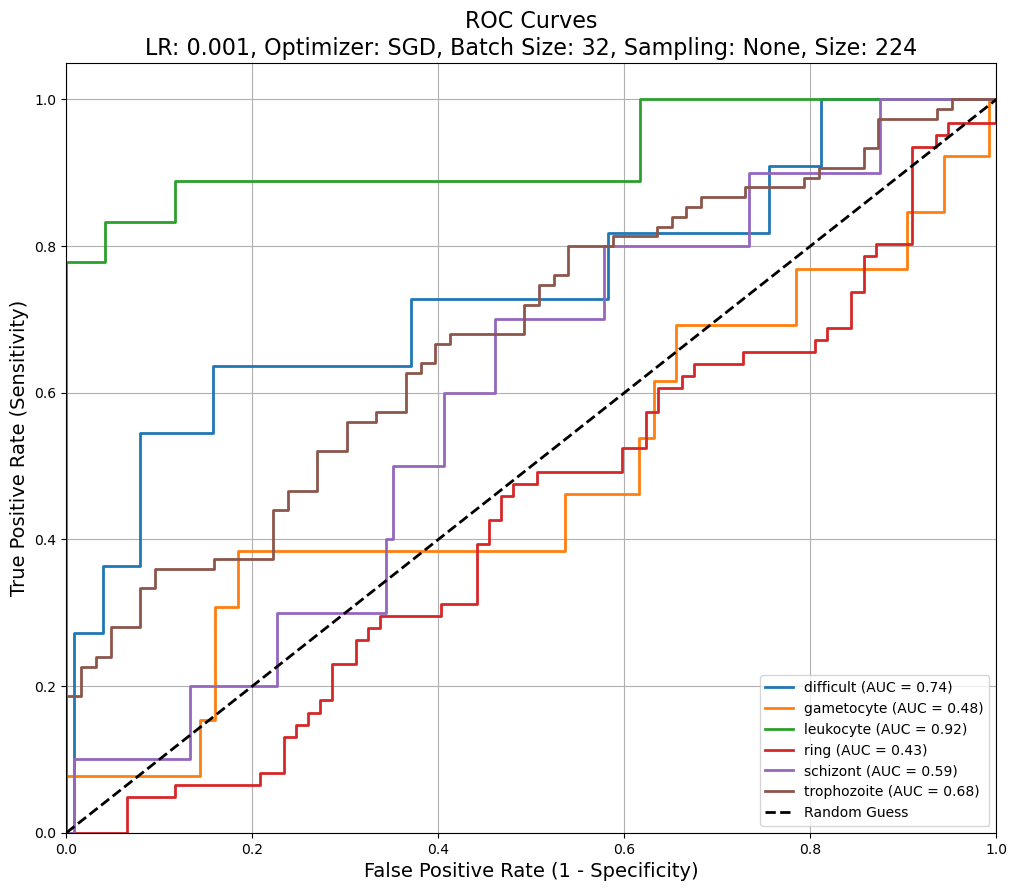

Evaluating Models:  88%|████████▊ | 14/16 [04:15<00:37, 18.79s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}


Validating (multi-label): 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6038
Skipping red blood cell (only one class present in y_true).


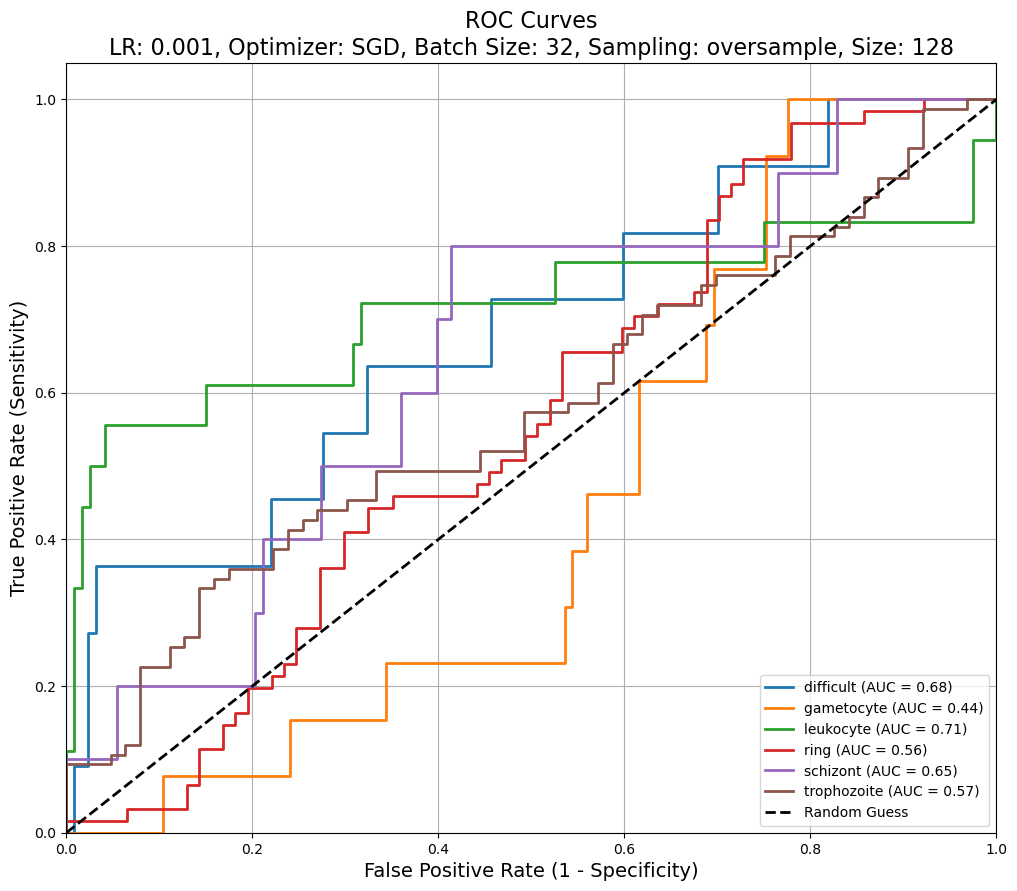

Evaluating Models:  94%|█████████▍| 15/16 [04:32<00:18, 18.30s/it]


Generating ROC Plot for model with params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}


Validating (multi-label): 100%|██████████| 5/5 [00:21<00:00,  4.21s/it]
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Overall Macro-Average AUC: nan
Skipping red blood cell (only one class present in y_true).
Robust Macro-Average AUC (on 6/7 classes): 0.6050
Skipping red blood cell (only one class present in y_true).


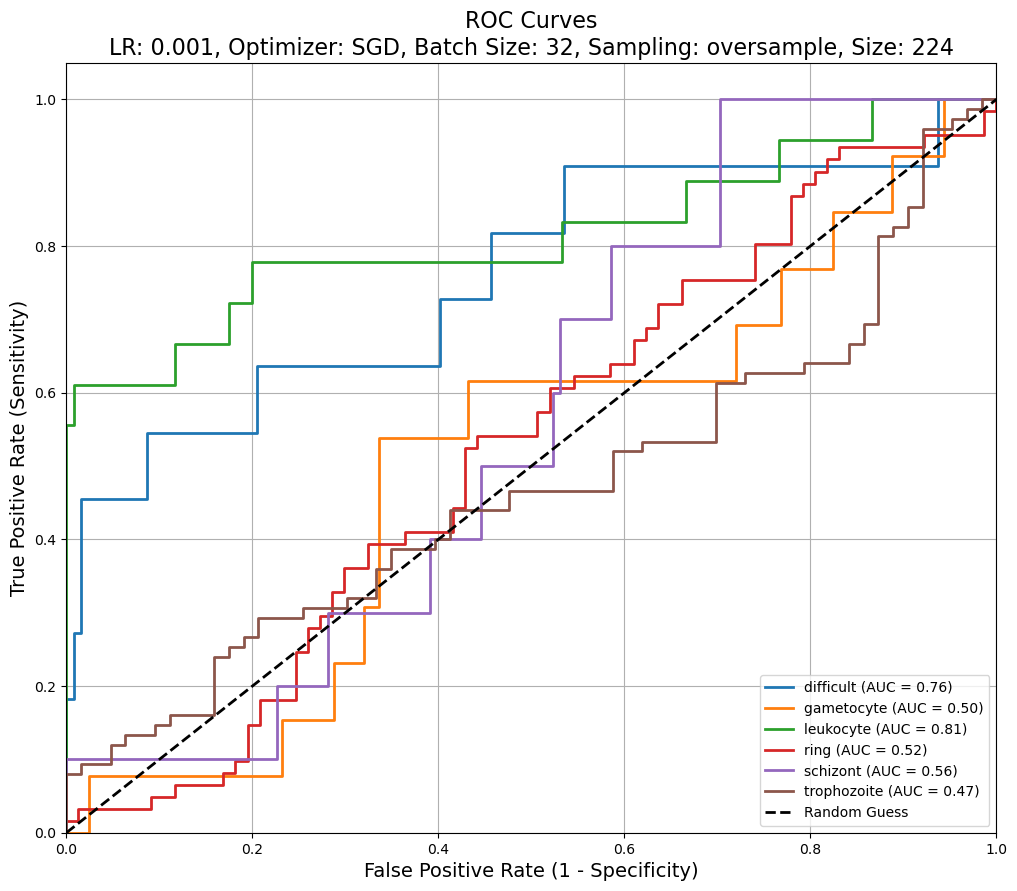

Evaluating Models: 100%|██████████| 16/16 [04:54<00:00, 18.42s/it]


--- Final Model Ranking (by Macro-Average AUC) ---
        lr optimizer  batch_size    sampling  image_size  macro_auc
8   0.0010      Adam          32        None         128   0.800874
9   0.0010      Adam          32        None         224   0.766895
11  0.0010      Adam          32  oversample         224   0.719293
1   0.0001      Adam          32        None         224   0.700104
10  0.0010      Adam          32  oversample         128   0.684620
2   0.0001      Adam          32  oversample         128   0.677632
0   0.0001      Adam          32        None         128   0.672529
3   0.0001      Adam          32  oversample         224   0.668964
13  0.0010       SGD          32        None         224   0.639723
12  0.0010       SGD          32        None         128   0.634077
5   0.0001       SGD          32        None         224   0.615804
15  0.0010       SGD          32  oversample         224   0.605019
14  0.0010       SGD          32  oversample         128   0.603

In [ ]:
# --- NEW: Initialize a list to store the summary results for each model ---
model_summary_data = []

# --- 1. Use glob to find all saved model files ---
model_paths = glob.glob(os.path.join(models_dir, "*.pth"))
print(f"Found {len(model_paths)} models to evaluate using glob.")

# --- 2. Loop through each found model path ---
for model_path in tqdm(model_paths, desc="Evaluating Models"):
    model_filename = os.path.basename(model_path)
    
    # Parse the filename to reconstruct the parameters
    pattern = r"model_lr-(.*)_optim-(.*)_bs-(.*)_sampling-(.*)_size-(.*)\.pth"
    match = re.match(pattern, model_filename)
    if not match:
        print(f"\nSkipping file with unrecognized name format: {model_filename}")
        continue
    
    lr, optimizer, batch_size, sampling, image_size = match.groups()
    params = {
        'lr': float(lr),
        'optimizer': optimizer,
        'batch_size': int(batch_size),
        'sampling': sampling if sampling != 'none' else None,
        'image_size': int(image_size)
    }

    print(f"\n{'='*60}\nGenerating ROC Plot for model with params: {params}\n{'='*60}")

    # Load the model
    model = EfficientNetDetector(num_classes=num_classes).to(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Create DataLoader
    test_transform = transforms.Compose([
        transforms.Resize((params['image_size'], params['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_ds = MalariaDataset(
        test_json_path, image_path,
        transform=test_transform, category_map=category_map
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=params['batch_size'],
        shuffle=False,
        collate_fn=detection_collate
    )

    # Run validation to get scores
    _, _, y_true, _, y_score = validate_model_multilabel(
        model, test_loader, device, category_map, return_preds=True
    )

    # --- Calculate and store the macro-average AUC ---
    try:
        macro_auc = roc_auc_score(y_true, y_score, average='macro')
        print(f"Overall Macro-Average AUC: {macro_auc:.4f}")
    except Exception as e:
        print(f"Could not calculate macro AUC for {params}. Error: {e}")
        macro_auc = np.nan
    
    valid_aucs = []
    for i in range(num_classes):
        if len(np.unique(y_true[:, i])) > 1:  # Needs both 0 and 1
            auc_score = roc_auc_score(y_true[:, i], y_score[:, i])
            valid_aucs.append(auc_score)
        else:
            print(f"Skipping {class_names[i]} (only one class present in y_true).")

    if valid_aucs:
        macro_auc = np.mean(valid_aucs)
        print(f"Robust Macro-Average AUC (on {len(valid_aucs)}/{num_classes} classes): {macro_auc:.4f}")
    else:
        macro_auc = np.nan
        print("Could not calculate macro AUC for any class.")


    # Save one row per model
    summary_row = params.copy()
    summary_row['macro_auc'] = macro_auc
    model_summary_data.append(summary_row)

    # --- Generate and display the per-class ROC plot ---
    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(class_names):
        # Skip if the class has no variation
        if len(np.unique(y_true[:, i])) < 2:
            print(f"Skipping {class_name} (only one class present in y_true).")
            continue

        y_true_class = y_true[:, i]
        y_score_class = y_score[:, i]

        fpr, tpr, _ = roc_curve(y_true_class, y_score_class)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    title = (
        f"ROC Curves\nLR: {params['lr']}, Optimizer: {params['optimizer']}, "
        f"Batch Size: {params['batch_size']}, Sampling: {params.get('sampling', 'none')}, "
        f"Size: {params['image_size']}"
    )
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# --- Save the final summary DataFrame after the loop ---
if model_summary_data:
    summary_df = pd.DataFrame(model_summary_data)
    summary_df_sorted = summary_df.sort_values(by='macro_auc', ascending=False)

    summary_path = os.path.join(models_dir, "macro_auc_summary.csv")
    summary_df_sorted.to_csv(summary_path, index=False)

    print("\n" + "="*50)
    print("--- Final Model Ranking (by Macro-Average AUC) ---")
    print("="*50)
    print(summary_df_sorted)
    print(f"\nSummary of macro AUC scores saved to: {summary_path}")
